In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import sys

In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [4]:
# Import FBP
sys.path.append('../FBPConvNet/')
from FBPConvNet import FBPConvNet

# Generate Example Data

In [5]:
def preprocess(data):
    return torch.Tensor(data).unsqueeze(1)
def target_ones(N,gpu=False):
    if GPU:
        return torch.ones(N,1).cuda()
    else:
        return torch.ones(N,1)
def target_zeros(N,gpu=False):
    if GPU:
        return torch.zeros(N,1).cuda()
    else:
        return torch.zeros(N,1)   

In [86]:
# set path to data
pathtodata = '../EllipseGeneration/RandomLineEllipses15.hdf5'
dataset_size = 200
batch_size = 1

In [87]:
f = h5py.File(pathtodata,'r')
print(f['ellip/training_data'].shape)
fakeinput = preprocess(f['ellip/training_data'][0:dataset_size])
fakelabels = preprocess(f['ellip/training_labels'][0:dataset_size])
reallabels = preprocess(f['ellip/training_labels'][dataset_size:2*dataset_size])
#f.close()

(400, 256, 256)


In [88]:
faketrainset = TensorDataset(fakeinput,fakelabels)
#realset = TensorDataset(reallabels)

faketrainloader = DataLoader(faketrainset,batch_size=batch_size,shuffle=True)
realtrainloader = DataLoader(reallabels, batch_size=batch_size,shuffle=True)

In [ ]:
len(realtrainloader)
realiter = iter(realtrainloader)
for i in range(len(realtrainloader)):
    data = realiter.next()
    print(data.size())

In [ ]:
fakeinput.size()

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Input 1 x 256 x 256 -> 64 x 256 x 256
        self.conv1 = nn.Conv2d(1,64,3,padding=1,stride=1)    
        self.batch1 = nn.BatchNorm2d(64)
        
        # -> 128 x 128 x 128
        self.conv2 = nn.Conv2d(64,128,7,padding=3,stride=2)
        self.batch2 = nn.BatchNorm2d(128)

        # -> 256 x 32 x 32 -> 256 x 22 x 22
        self.conv3 = nn.Conv2d(128,256,5,padding=2,stride=2)
        self.batch3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,256,7,padding=3,stride=3)
        self.batch4 = nn.BatchNorm2d(256)
        
        # -> 512 x 8 x 8
        self.conv5 = nn.Conv2d(256,512,5,padding=2,stride=3)
        self.batch5 = nn.BatchNorm2d(512)
        
        # -> 1024 x 1 x 1
        self.conv6 = nn.Conv2d(512,1024,5,padding=2,stride=3)
        self.batch6 = nn.BatchNorm2d(1024)
        self.conv7 = nn.Conv2d(1024,1024,3,padding=1,stride=3)
        #self.batch7 = nn.BatchNorm2d(1024)
        
        # Decision layers
        self.conv8 = nn.Conv2d(1024,1024,1)
        self.conv9 = nn.Conv2d(1024,1024,1)
        self.conv10 = nn.Conv2d(1024,1,1)
        
        # Non-Linear Activations
        self.leaky = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv2_drop = nn.Dropout2d(p=.2)
        
        
        
    def forward(self,x):
        # Generate Features
        x = self.leaky(self.batch1(self.conv1(x)))
        x = self.leaky(self.batch2(self.conv2(x)))
        x = self.leaky(self.batch3(self.conv3(x)))
        x = self.leaky(self.batch4(self.conv4(x)))
        x = self.leaky(self.batch5(self.conv5(x)))
        x = self.leaky(self.batch6(self.conv6(x)))
        x = self.leaky(self.conv7(x))
        
        # Decision Layers
        x = self.leaky(self.conv2_drop(self.conv8(x)))
        x = self.leaky(self.conv2_drop(self.conv9(x)))
        x = self.sigmoid(self.conv10(x))
        return x[:,:,0,0]
#         x1_1 = self.batch1(self.elu(self.conv1_1(x)))
#         x1_2 = self.batch1(self.elu(self.conv1_2(x1_1)))
#         x1_3 = self.batch1(self.elu(self.conv1_2(x1_2)))
#         x1 = self.maxpool(x1_3)
        
#         x2_1 = self.batch2(self.elu(self.conv2_1(x1)))
#         x2_2 = self.batch2(self.elu(self.conv2_2(x2_1)))
#         x2 = self.maxpool(x2_2)
        
#         x3_1 = self.batch3(self.elu(self.conv3_1(x2)))
#         x3_2 = self.batch3(self.elu(self.conv3_2(x3_1)))
#         x3 = self.maxpool(x3_2)
        
#         x4_1 = self.batch4(self.elu(self.conv4_1(x3)))
#         x4_2 = self.batch4(self.elu(self.conv4_2(x4_1)))

#         x5_1 = self.deconv5(x4_2)
#         x5_2 = torch.cat((x3_2,x5_1),1)
#         x5_3 = self.batch3(self.elu(self.conv5_1(x5_2)))
#         x5 = self.batch3(self.elu(self.conv5_2(x5_3)))
        
#         x6_1 = self.deconv6(x5)
#         x6_2 = torch.cat((x2_2,x6_1),1)
#         x6_3 = self.batch2(self.elu(self.conv6_1(x6_2)))
#         x6 = self.batch2(self.elu(self.conv6_2(x6_3)))
        
#         x7_1 = self.deconv7(x6)
#         x7_2 = torch.cat((x1_3,x7_1),1)
#         x7_3 = self.batch1(self.elu(self.conv7_1(x7_2)))
#         x7 = self.batch1(self.elu(self.conv7_2(x7_3)))
        
#         x8 = self.conv8(x7)
#         y = x8 + x
        
#         return y

In [ ]:
net = Discriminator().cuda()
x = Variable(fakeinput)
print(x.size())
out = net.forward(x)
print(out.size())
print(out)

In [ ]:
m = nn.Softplus()
input_ = Variable(torch.randn(2))
print(input_)
print(m(input_))

# Training Pseudocode

In [10]:
import time

In [202]:
D = Discriminator()
G = FBPConvNet()

In [203]:
torch.cuda.empty_cache()
num_epochs = 100
d_steps = 1
g_steps = 1
batch_size = 1

criterion = nn.BCELoss()
mseloss = nn.MSELoss()

d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

GPU = True
if GPU:
    D = D.cuda()
    G = G.cuda()


In [204]:
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)

G.train()
for epoch in range(num_epochs):
    print('Epoch %i'%(epoch))
    epochstart = time.time()
    
    fakeiter = iter(faketrainloader)
    realiter = iter(realtrainloader)
    
    Giter = iter(faketrainloader)
    for batch_index in range(len(realtrainloader)):
        ## prepare data
        truelabels = realiter.next()
        fakeinput, _ = fakeiter.next()
        
        gfakeinput, gfakelabel = Giter.next()
        
        if GPU:
            truelabels = truelabels.cuda()
            fakeinput = fakeinput.cuda()
#             fakelabel = fakelabel.cuda()
        
        ## Train D
        d_optimizer.zero_grad()
        
        # Train D on real
        d_real_data = Variable(truelabels)
        d_real_decision = D(d_real_data)
        d_real_error = criterion(d_real_decision, Variable(target_ones(batch_size,GPU)))
        d_real_error.backward()
        
        # Train D on fake
        d_gen_input = Variable(fakeinput)
        d_fake_data = G(d_gen_input).detach() # detach to avoid training G on these labels
        d_fake_decision = D(d_fake_data)
        d_fake_error = criterion(d_fake_decision, Variable(target_zeros(batch_size,GPU))) 
        d_fake_error.backward()
        d_optimizer.step()
        d_losses[epoch] += d_real_error+d_fake_error
        
        ## Train G
        if GPU:
            gfakeinput = gfakeinput.cuda()
            gfakelabel = gfakelabel.cuda()
        g_optimizer.zero_grad()
        
        gen_input = Variable(gfakeinput)
        g_fake_data = G(gen_input)
        dg_fake_decision = D(g_fake_data)
        g_error = criterion(dg_fake_decision, Variable(target_ones(batch_size,GPU)))
        mse_error =  mseloss(g_fake_data,Variable(gfakelabel))
        #print('\t g_error %.3f, mse_error %.3f' % (g_error,mse_error))
        g_error += 5*mse_error
        g_error.backward()
        g_optimizer.step()
        g_losses[epoch] += g_error
    d_losses[epoch] /= dataset_size
    g_losses[epoch] /= dataset_size
    print('\tD Loss %f' % (d_losses[epoch]))
    print('\tG Loss %f' % (g_losses[epoch]))
    epochend = time.time()
    print('\tTraining Time: %.3f seconds' % (epochend-epochstart))


Epoch 0
	D Loss 0.954332
	G Loss 3.399124
	Training Time: 66.870 seconds
Epoch 1
	D Loss 0.551848
	G Loss 4.823844
	Training Time: 67.299 seconds
Epoch 2
	D Loss 0.314974
	G Loss 6.637968
	Training Time: 67.255 seconds
Epoch 3
	D Loss 0.541668
	G Loss 5.760881
	Training Time: 67.258 seconds
Epoch 4
	D Loss 0.670114
	G Loss 5.970843
	Training Time: 67.571 seconds
Epoch 5
	D Loss 0.147147
	G Loss 10.748810
	Training Time: 67.945 seconds
Epoch 6
	D Loss 0.450507
	G Loss 8.331328
	Training Time: 67.695 seconds
Epoch 7
	D Loss 0.521647
	G Loss 5.413647
	Training Time: 67.067 seconds
Epoch 8
	D Loss 0.459536
	G Loss 6.806431
	Training Time: 67.560 seconds
Epoch 9
	D Loss 0.479428
	G Loss 5.178638
	Training Time: 67.646 seconds
Epoch 10
	D Loss 0.423761
	G Loss 4.834047
	Training Time: 67.532 seconds
Epoch 11
	D Loss 0.425549
	G Loss 5.609101
	Training Time: 66.958 seconds
Epoch 12
	D Loss 0.333147
	G Loss 5.511364
	Training Time: 67.310 seconds
Epoch 13
	D Loss 0.360066
	G Loss 6.639561
	Tra

Text(0.5,1,'Generator Losses')

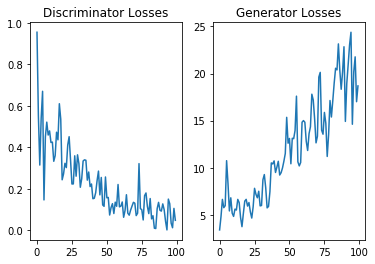

In [205]:
plt.figure()
plt.subplot(121)
plt.plot(d_losses)
plt.title('Discriminator Losses')
plt.subplot(122)
plt.plot(g_losses)
plt.title('Generator Losses')

In [206]:
fakeiter = iter(faketrainloader)

(-0.5, 255.5, 255.5, -0.5)

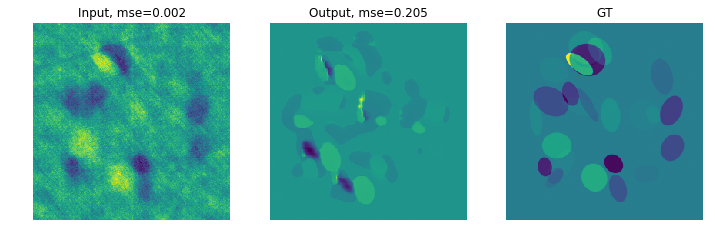

In [214]:
y,x = fakeiter.next()

GPU = True
if GPU:
    xhat = G(Variable(y.cuda()))
    xhat = xhat.cpu().data
else:
    xhat = G(Variable(y)).data
plt.figure(figsize=(12,4))
plt.subplot(131)
mse =torch.mean((y[0,0,:,:]-x[0,0,:,:])**2)
plt.imshow(y[0,0,...].numpy())
plt.title('Input, mse=%.3f'%(mse))
plt.axis('off')

mse =torch.mean((xhat[0,0,:,:]-x[0,0,:,:])**2)
plt.subplot(132)
plt.imshow(xhat[0,0,...].numpy())
plt.title('Output, mse=%.3f'%(mse))
plt.axis('off')

plt.subplot(133)
plt.imshow(x[0,0,...].numpy())
plt.title('GT')
plt.axis('off')

In [157]:
print(np.min(y.numpy()),np.max(y.numpy()))

-0.4099816 0.3664893


In [215]:
G = G.cpu()
torch.save(G.state_dict(),'Gmse_100.weights')
D = D.cpu()
torch.save(D.state_dict(),'Dmse_100.weights')

if GPU:
    G = G.cuda()
    D = D.cuda()
